<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_with_blurry_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.0543 - accuracy: 0.9409
Epoch 1: val_accuracy improved from -inf to 0.97966, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 40s 768ms/step - loss: 1.0543 - accuracy: 0.9409 - val_loss: 0.4192 - val_accuracy: 0.9797
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9946
Epoch 2: val_accuracy improved from 0.97966 to 0.98279, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5
38/38 [==============================] - 11s 281ms/step - loss: 0.1185 - accuracy: 0.9946 - val_loss: 0.1815 - val_accuracy: 0.9828
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9987
Epoch 3: val_accuracy did not improve from 0.98279
38/38 [==============================] - 12s 326ms/step - loss: 0.0156 - accuracy: 0.9987 - val_loss: 0.2351 - val_accuracy: 0.9781
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9899
Epoch 4: val_accuracy did not improve from 0.98279
38/38 [==============================] - 12s 328ms/step - loss: 0.1433 - accuracy: 0.9899 - val_loss: 0.273

(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

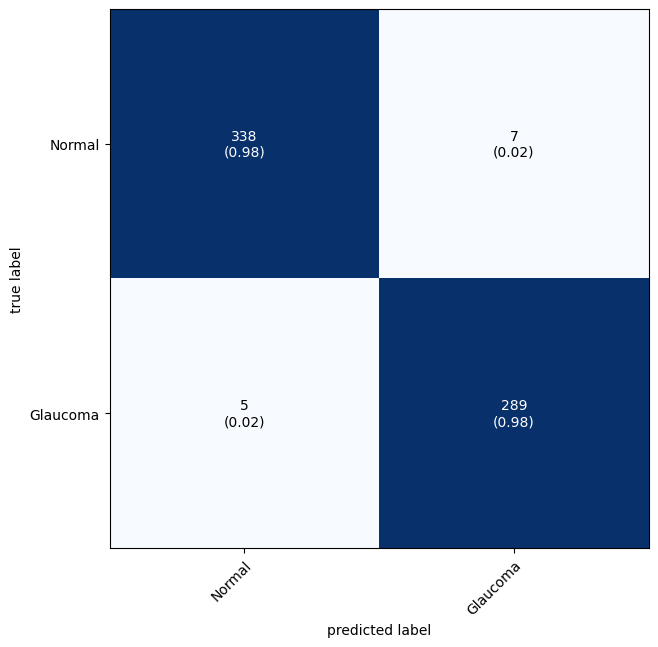

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path):
    images = []
    labels = []
    blurs = []
    label_blur = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" or folder_name == "glucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)

            # Check if img is not None before processing
            if img is not None:
                img = cv2.resize(img, (224, 224))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.Laplacian(gray, cv2.CV_64F).var()

                # Set a threshold for blur
                if blur > 150:
                    images.append(img)
                    labels.append(label)
                else:
                    blurs.append(img)
                    label_blur.append(label)

    return np.array(images), np.array(labels), np.array(blurs), np.array(label_blur)

# Load images from the source folder (high-quality images)
source_dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'
test_dataset_path = '/content/drive/MyDrive/glaucoma_dataset/test'
x_source, y_source, _, _ = load_images_from_folder(source_dataset_path)
x_test, y_test, _, _ =load_images_from_folder(test_dataset_path)

y_source = y_source.astype(int)

# Apply oversampling using SMOTE in the source domain
oversample_source = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled_source, y_train = oversample_source.fit_resample(x_source.reshape(-1, 224 * 224 * 3), y_source)

# Reshape back to image format in the source domain
x_trainy = x_resampled_source.reshape(-1, 224, 224, 3)

# Split the data into training and validation sets for the source domain
x_train, x_val, y_train, y_val = train_test_split(x_trainy, y_train, test_size=0.3, random_state=42)

# Split the data into training and validation sets

# Model architecture with dropout for regularization
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dropout(0.5))  # Add dropout layer for regularization
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model callbacks
callbacks_list = [
    ModelCheckpoint("/content/drive/MyDrive/vgg19_glaucoma.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode='max')
]

# Train the model
history = model.fit(x_train, y_train, batch_size=40,
                    epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list,
                    class_weight={0: 1.0, 1: 1.0})  # Class weights can be adjusted based on requirements


# Evaluate the model on the target domain (testing set)
loss, accuracy = model.evaluate(x_val, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)

loss1, accuracy1 = model.evaluate(x_test, y_test)
print("Loss:", loss1)
print("Accuracy:", accuracy1)

y_pred = (model.predict(x_val) > 0.5).astype(int)
print("Accuracy Score:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)

In [ ]:
model.save('/content/drive/MyDrive/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 144ms/step


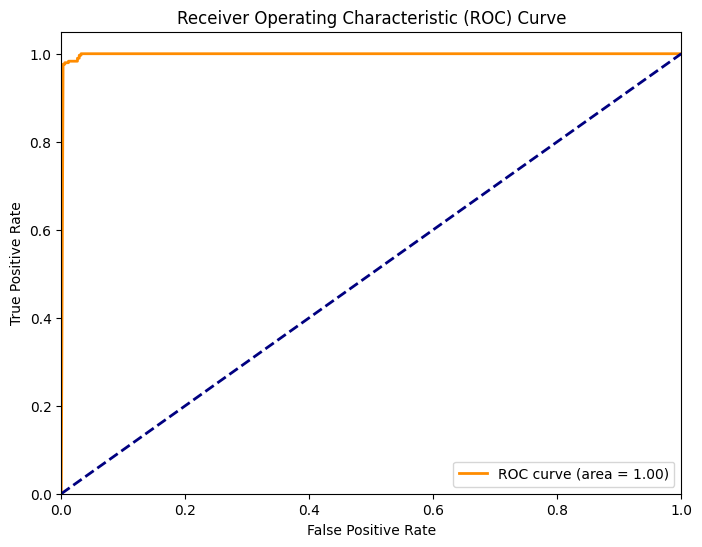

In [3]:
from sklearn.metrics import roc_curve, auc

y_probs = model.predict(x_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

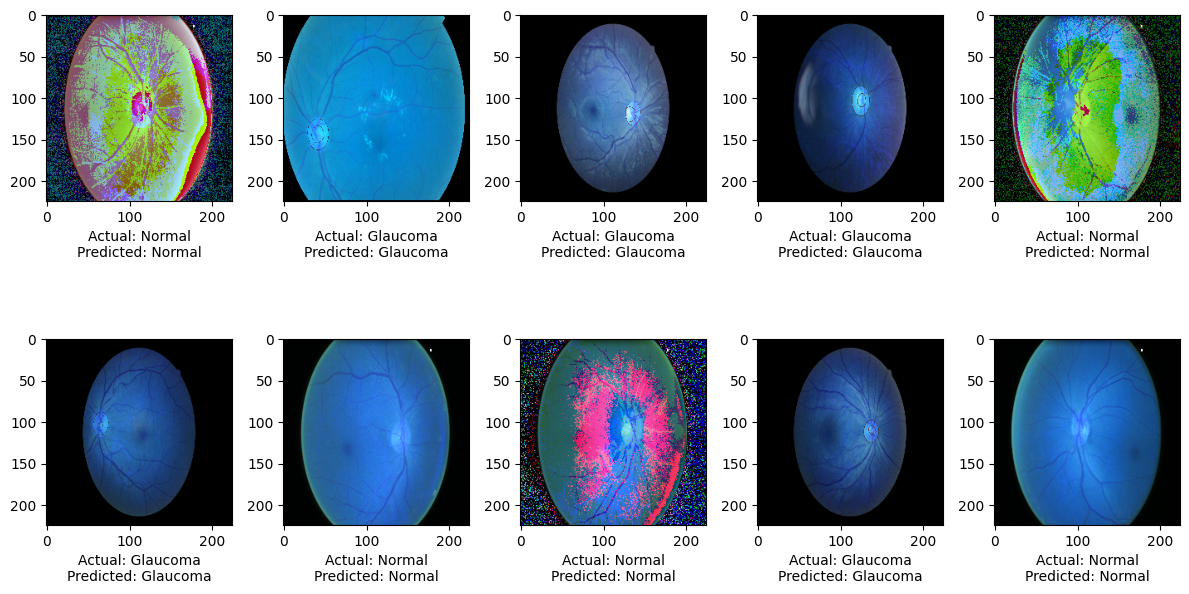

In [7]:
#samples images with the predicted and actual label
import random

plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_val)))
    image = x_val[sample]
    category = y_val[sample]
    pred_category = y_pred[sample]

    label = "Normal" if category == 0 else "Glaucoma"
    pred_label = "Normal" if pred_category == 0 else "Glaucoma"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"Actual: {label}\nPredicted: {pred_label}")
plt.tight_layout()
plt.show()